In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
data = pandas.read_excel('../raw_data/weekly_data_clean.xlsx', engine='openpyxl')
data = data.drop(columns=['Unnamed: 0', 'date_issue'])

In [3]:
dataset = data.values
dataset = dataset.astype('float32')

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
train_size = int(len(dataset) * 0.85)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

112 20


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [7]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [8]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
# create and fit the LSTM network

model = Sequential()

# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

model.add(LSTM(32, activation='tanh', return_sequences=False))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

In [10]:
model.compile(optimizer='RMSprop',
            loss='MeanSquaredError',
            metrics=['mse', 'mae', 'mape']
            )

In [11]:
# from tensorflow.keras.callbacks import EarlyStopping

# es = EarlyStopping(patience=50, restore_best_weights=True)

history = model.fit(trainX, trainY,
                #validation_split=0.2,
                epochs=200,
                verbose=1,
                batch_size=16
                #callbacks=[es]
                )

Epoch 1/200
7/7 [==============================] - 4s 5ms/step - loss: 0.0380 - mse: 0.0380 - mae: 0.1654 - mape: 77.6438
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0845 - mape: 64.1006
Epoch 3/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0962 - mape: 75.8976
Epoch 4/200
7/7 [==============================] - 0s 12ms/step - loss: 0.0102 - mse: 0.0102 - mae: 0.0787 - mape: 59.7052
Epoch 5/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0824 - mape: 56.7948
Epoch 6/200
7/7 [==============================] - 0s 11ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0764 - mape: 53.8786
Epoch 7/200
7/7 [==============================] - ETA: 0s - loss: 0.0099 - mse: 0.0099 - mae: 0.0778 - mape: 61.404 - 0s 13ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0783 - mape: 59.2858
Epoch 8/200
7/7 [==============================] - 0s 13ms/step - loss: 

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [13]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [14]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 256095.93 RMSE
Test Score: 506192.59 RMSE


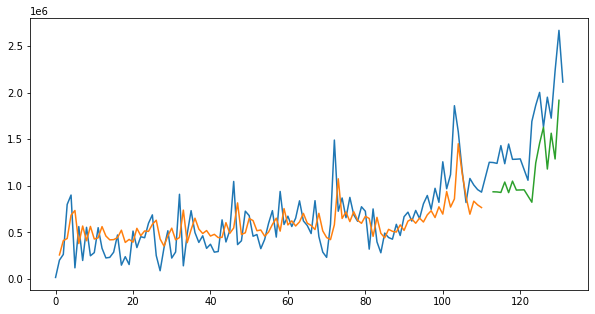

In [19]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(10,5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()